In [12]:
import pandas as pd
import numpy as np
import seaborn as sns # Вдруг порисовать захочу:)
import matplotlib.pyplot as plt

In [100]:
# Выгружаю csv-файлы 

customers = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-m-korneeva-25/Karpov_courses/olist_customers_dataset.csv')
orders = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-m-korneeva-25/Karpov_courses/olist_orders_dataset.csv')
order_items = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-m-korneeva-25/Karpov_courses/olist_order_items_dataset.csv')


In [28]:
# Я буду считать покупкой только уже доставленные заказы, т.к. до получения заказа его ещё можно отменить или изменить.
#Ограничение по столбцу времени оплаты на случай ошибок или кредита 
#Кредит я покупокй не считаю, т.к. деньги за товар потенциальный покупатель пока не отдал и компания их ещё не получила

orders \
    .query('order_status == "delivered" & order_approved_at != "NaN"') \
    .groupby('customer_id', as_index = False) \
    .agg({'order_id' : 'count'}) \
    .sort_values('order_id', ascending = False)

#ПРОВЕРИТЬ УНИКАЛЬНЫЕ ЗНАЧЕНИЯ!!!

,customer_id,order_id
0,00012a2ce6f8dcda20d059ce98491703,1
64315,aa5e0a0c36015d39de864189a2b00b09,1
64324,aa6190994371836fc1d4596edd827abd,1
64323,aa606152f23a5fa9ba3d0b87f7a492e8,1
64322,aa601b3c45980c0918042d5ca7a25054,1
...,...,...
32157,5584b1ace8b18cc156ce51b989fd2958,1
32156,558499c2027ec01d530fb975ce2e5b2f,1
32155,55846a9bb9076de56da44e430349ad1a,1
32154,55840ff4caf1d80ac296d0b1ac968b53,1


In [34]:
#Одни подозрительные еденички. Смотрю, по какому принципу присваиваются показанные идентификаторы уникальным 

customers \
    .groupby('customer_unique_id', as_index = False) \
    .agg({'customer_id' : 'count'}) \
    .sort_values('customer_id', ascending = False)


,customer_unique_id,customer_id
52973,8d50f5eadf50201ccdcedfb9e2ac8455,17
23472,3e43e6105506432c953e165fb2acf44c,9
37797,6469f99c1f9dfae7733b25662e7f1782,7
76082,ca77025e7201e3b30c44b472ff346268,7
10354,1b6c7548a2a1f9037c1fd3ddfed95f33,7
...,...,...
32508,5657dfebff5868c4dc7e8355fea865c4,1
32507,5657596addb4d7b07b32cd330614bdf8,1
32506,5656eb169546146caeab56c3ffc3d268,1
32505,5656a8fabc8629ff96b2bc14f8c09a27,1


In [ ]:
'''
Судя по этим двум таблицам, показанный идентификатор пользователя на каждый заказ создаётся новый и 
добавляется к списку других показанных идентификаторов каждого пользователя.
В таком случае количество покупок пользователя равно количеству его показанных идентификаторов.
'''

In [41]:
customers_orders = customers.merge(orders, how = 'inner', on = 'customer_id') \
    .query('order_status == "delivered" & order_approved_at != "NaN"') \
    .groupby('customer_unique_id', as_index = False) \
    .agg({'customer_id' : 'count'}) \
    .rename(columns = {'customer_id':'purchases_count'}) \
    .query('purchases_count == "1"') \
    

customers_orders.shape
# Итак, у нас 90'577 человек, купивших в данном сервисе только один раз (отмены не считаются)

(90557, 2)

In [128]:
# Убираю время и день из даты
orders['order_purchase_timestamp'] = orders.order_purchase_timestamp.apply(lambda x: '-'.join(x.split()[0].split('-')[:2]))
# Смотрю количество отменённых или недоступных заказов в разбивке по году-месяцу

orders \
    .query('order_status == "unavailable" | order_status == "canceled"') \
    .groupby(['order_purchase_timestamp', 'order_status'], as_index = False) \
    .agg({'order_id':'count'}) \
    .rename(columns = {'order_id':'not_delivered_orders_count'})[:10] # Так места меньше занимает


,order_purchase_timestamp,order_status,not_delivered_orders_count
0,2016-09,canceled,2
1,2016-10,canceled,24
2,2016-10,unavailable,7
3,2017-01,canceled,3
4,2017-01,unavailable,10
5,2017-02,canceled,17
6,2017-02,unavailable,45
7,2017-03,canceled,33
8,2017-03,unavailable,32
9,2017-04,canceled,18


In [125]:
# Среднее для недоступных заказов
not_delivered_mean_orders_by_unavailable = orders \
    .query('order_status == "unavailable"') \
    .groupby(['order_purchase_timestamp', 'order_status'], as_index = False) \
    .agg({'order_id':'count'}) \
    .rename(columns = {'order_id':'not_delivered_orders_count'}) \
    .rename(columns = {'not_delivered_orders_count': 'unavailable_mean'}) \
    .mean()
    

#Среднее для отменённых заказов
not_delivered_mean_orders_by_canceled = orders \
    .query('order_status == "canceled"') \
    .groupby(['order_purchase_timestamp', 'order_status'], as_index = False) \
    .agg({'order_id':'count'}) \
    .rename(columns = {'order_id':'not_delivered_orders_count'}) \
    .rename(columns = {'not_delivered_orders_count': 'canceled_mean'}) \
    .mean()

print('not_delivered_mean_orders_by_canceled is ', not_delivered_mean_orders_by_canceled['canceled_mean'], '\n',
      'not_delivered_mean_orders_by_unavailable is ', not_delivered_mean_orders_by_unavailable['unavailable_mean'])


not_delivered_mean_orders_by_canceled is  26.041666666666668 
 not_delivered_mean_orders_by_unavailable is  29.0


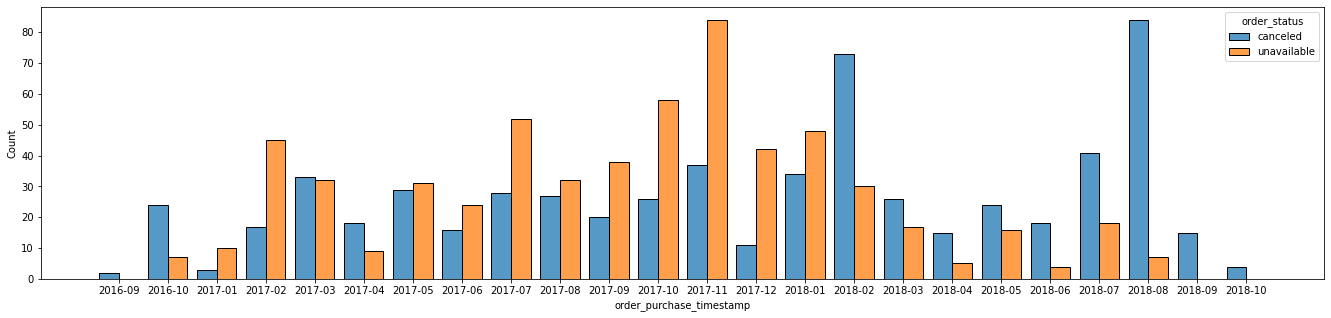

In [129]:
not_delivered_orders = orders \
    .query('(order_status == "unavailable" | order_status == "canceled")') \
    .sort_values('order_purchase_timestamp', ascending = True)

# Рисую распределение по причинам недоставки заказа в месяц
plt.figure(figsize=(23, 5)) # Подогнала, чтобы было нормально видно даты
sns.histplot(not_delivered_orders, x='order_purchase_timestamp', hue='order_status', shrink=.8, multiple="dodge")

In [ ]:
# Получилось забавно. Со временем сошло на нет количество недоступных заказов
#(правда, оно с нуля и начиналось, видимо, программисты начудили:) )

In [103]:
orders[:10] 

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00
5,a4591c265e18cb1dcee52889e2d8acc3,503740e9ca751ccdda7ba28e9ab8f608,delivered,2017-07,2017-07-09 22:10:13,2017-07-11 14:58:04,2017-07-26 10:57:55,2017-08-01 00:00:00
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04,2017-04-13 13:25:17,NaN,NaN,2017-05-09 00:00:00
7,6514b8ad8028c9f2cc2374ded245783f,9bdf08b4b3b52b5526ff42d37d47f222,delivered,2017-05,2017-05-16 13:22:11,2017-05-22 10:07:46,2017-05-26 12:55:51,2017-06-07 00:00:00
8,76c6e866289321a7c93b82b54852dc33,f54a9f0e6b351c431402b8461ea51999,delivered,2017-01,2017-01-25 02:50:47,2017-01-26 14:16:31,2017-02-02 14:08:10,2017-03-06 00:00:00
9,e69bfb5eb88e0ed6a785585b27e16dbf,31ad1d1b63eb9962463f764d4e6e0c9d,delivered,2017-07,2017-07-29 12:05:32,2017-08-10 19:45:24,2017-08-16 17:14:30,2017-08-23 00:00:00
